# Analyzing Variation Due to Random Seeds
---
*An analysis of the noise when retraining with fixed hyperparameters*

For more background, see the notebook [**Parametric Analysis**](../theory/parametric-analysis.ipynb).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

import opda.random
from opda.utils import normal_ppf

# constants

experiments = {
    "llama-33m_residual": {
        "family": "llama",
        "model": "Llama 33M",
        "dataset": "SlimPajama-6B",
        "metric": "cross-entropy",
    },
    "resnet18_residual": {
        "family": "resnet",
        "model": "ResNet18",
        "dataset": "ImageNet",
        "metric": "error rate",
    },
}

styles = {
    "empirical": {"linestyle": "--", "color": "#648FFF"},
    "theoretical": {"linestyle": "-", "color": "#FFB000"},
}

n_residual_groups = 8
n_residual_replicates = 128

confidence_residual = 0.95


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Testing our Assumptions

In [**Validating the Parametric Analysis in Practice**](./validating-the-parametric-analysis-in-practice.ipynb), we saw that the noisy quadratic distribution both describes real-world hyperparameter search and enables powerful inferences about it. Still, one might wonder whether the distribution just happens to match the data, or if the assumptions behind it truly explain what's going on.

Our theory stems from three basic assumptions:

  1. Expected test performance as a function of the hyperparameters is a thrice differentiable.
  2. The search distribution is absolutely continuous with respect to Lebesgue measure.
  3. The noise due to random seeds is normally distributed with a constant variance: $\mathcal{N}\left(0, \sigma\right)$.

The first two assumptions are fairly basic&mdash;most functions are either smooth or well-approximated as such, and we almost always use continuous distributions for continuous hyperparameters in random search. Moreover, these assumptions can even be relaxed! For example, the presence of discrete hyperparameters doesn't really impact the conclusions, the function needs to be thrice differentiable only *around the optimum*, and likewise the search distribution needs only to be continuous there as well.

Really, the third assumption makes the strongest claim. Luckily, it's easy to test! That's exactly what we'll do here.

## Experimental Design

To test that assumption, we'll take hyperparameter configurations and retrain them many times with different random seeds. Since our theory only concerns the distribution's tail, we only care if normality and homoskedasticity are satisfied in the asymptotic regime&mdash;where expected performance is above a threshold. Intuitively, we expect bad hyperparameters to produce unpredictable performance distributions, while good hyperparameters should exhibit nicer structure.

With this in mind, we designed the following experiment. Using the Llama 33M and ResNet18 results from [**Validating the Parametric Analysis in Practice**](./validating-the-parametric-analysis-in-practice.ipynb), we took the hyperparameter configurations that achieved validation scores higher than 12.5%, 25%, 37.5%, ..., and 100% of other configurations. Then, we retrained each of those 8 hyperparameter configurations 128 times. In our analysis, we'll look at the best validation score achieved at any point during training (i.e., with early stopping). In this way, we can see how performance varies given fixed hyperparameters but different random seeds.

In [2]:
# Load the data.
experiment_to_quantile_to_training_curves = {}
experiment_to_quantile_to_hparams_and_ys = {}
for experiment in experiments:
    family = experiments[experiment]["family"]
    with open(f"../../data/{family}/{experiment}.results.jsonl") as f_in:
        training_curves = []
        hparams, ys = [], []
        for ln in f_in:
            ex = json.loads(ln)
            if experiment.startswith("llama-33m"):
                training_curves.append([
                    (
                        step["step"],
                        step["val_raw_loss"] if not np.isnan(step["val_raw_loss"]) else np.inf,
                    )
                    for step in ex["learning_curve"]
                ])
                hparams.append({
                    k: v
                    for k, v in ex["hyperparameters"].items()
                    if k not in {
                        # The following hyperparameters were fixed during search.
                        "total_steps",
                        "n_embd",
                        "n_head",
                        "n_layer",
                        "sequence_length",
                        "wsd_fract_decay",
                        "seed",
                        "data_seed",
                    }
                })
                ys.append(min(
                    # Use the best cross-entropy achieved during training.
                    step["val_raw_loss"] if not np.isnan(step["val_raw_loss"]) else np.inf
                    for step in ex["learning_curve"]
                ))
            elif experiment.startswith("resnet18"):
                training_curves.append([
                    (
                        epoch["epoch"],
                        1 - epoch["top_1"],
                    )
                    for epoch in ex["learning_curve"]
                ])
                hparams.append({
                    key: ex[key]
                    for key in [
                        "epochs",
                        "batch_size",
                        "lr",
                        "lr_peak_epoch",
                        "momentum",
                        "weight_decay",
                        "label_smoothing",
                        "use_blurpool",
                    ]
                })
                ys.append(
                    # Use the best error rate, even if the loss later became NaN.
                    min(1 - epoch["top_1"] for epoch in ex["learning_curve"])
                    if len(ex["learning_curve"]) > 0 else
                    # Otherwise, use 1 if the loss became NaN in the first epoch.
                    1.,
                )
            else:
                raise RuntimeError(f"Unrecognized experiment: {experiment}.")

        experiment_to_quantile_to_training_curves[experiment] = {
            (i + 1) / n_residual_groups: training_curves[
                n_residual_replicates * i:n_residual_replicates * (i + 1)
            ]
            for i in range(n_residual_groups)
        }
        experiment_to_quantile_to_hparams_and_ys[experiment] = {
            (i + 1) / n_residual_groups: (
                hparams[n_residual_replicates * i:n_residual_replicates * (i + 1)],
                np.array(ys[n_residual_replicates * i:n_residual_replicates * (i + 1)]),
            )
            for i in range(n_residual_groups)
        }

# Validate the data.
for experiment, quantile_to_training_curves in experiment_to_quantile_to_training_curves.items():
    # Check the experiment has the expected number of groups.
    if len(quantile_to_training_curves) != n_residual_groups:
        raise RuntimeError(
            f"{experiment} experiment has the wrong number of groups.",
        )
    for quantile, training_curves in quantile_to_training_curves.items():
        # Check each group has the right number of observations.
        if len(training_curves) != n_residual_replicates:
            raise RuntimeError(
                f"{experiment} (quantile={quantile}) has the wrong number of examples.",
            )
for experiment, quantile_to_hparams_and_ys in experiment_to_quantile_to_hparams_and_ys.items():
    # Check the experiment has the expected number of groups.
    if len(quantile_to_hparams_and_ys) != n_residual_groups:
        raise RuntimeError(
            f"{experiment} experiment has the wrong number of groups.",
        )
    for quantile, (hparams, ys) in quantile_to_hparams_and_ys.items():
        # Check each group has homogenous hyperparameters.
        if len({tuple(d.items()) for d in hparams}) != 1:
            raise RuntimeError(
                f"{experiment} (quantile={quantile}) has heterogenous hyperparameters.",
            )
        # Check each group has the right number of observations.
        if len(hparams) != n_residual_replicates or len(ys) != n_residual_replicates:
            raise RuntimeError(
                f"{experiment} (quantile={quantile}) has the wrong number of examples.",
            )

## Checking Normality

In some sense, normality is a prerequisite for homoskedasticity; once you know a collection of distributions is normal, comparing their variances is a natural next step. Thus, we'll test normality first.

The standard way to assess normality is the venerable [normal probability plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Visual approaches, like normal probability plots, are almost always preferred to formal tests because we usually don't care about whether the distribution is *perfectly* normal; instead, we wish to know if it's (very) nearly normal, or at least normal enough for our purposes.

In addition to normal probability plots, we'll also show histograms as perhaps a more familiar visualization of the distributions' shapes.

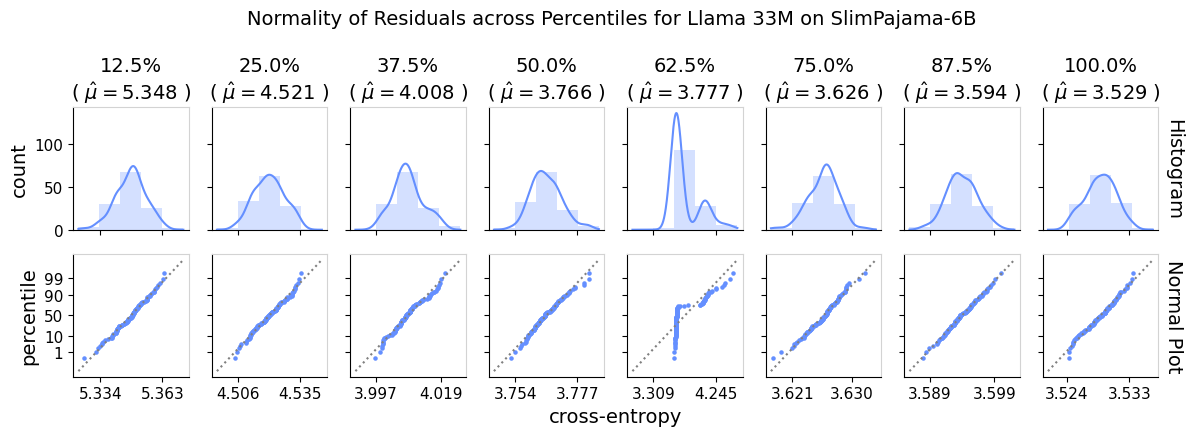

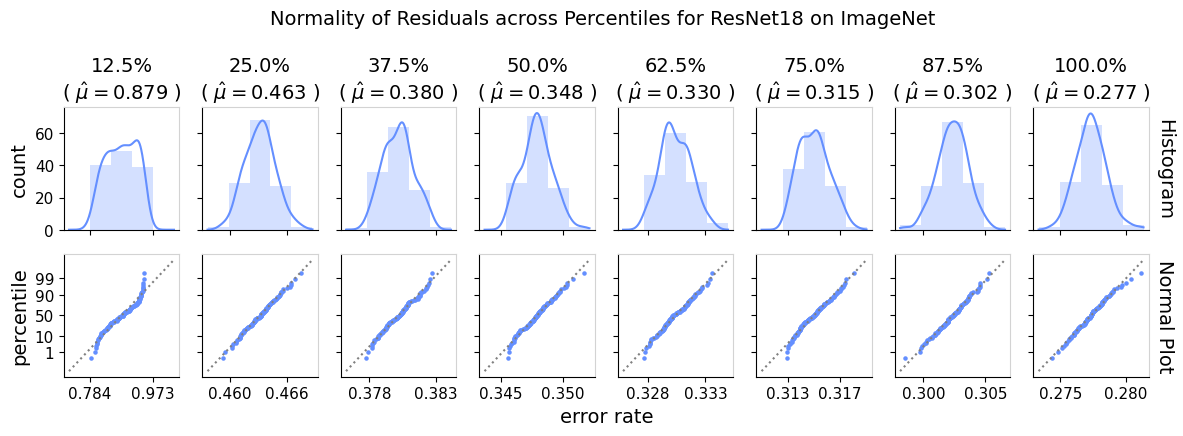

In [3]:
for experiment, quantile_to_hparams_and_ys in experiment_to_quantile_to_hparams_and_ys.items():
    fig, axes = plt.subplots(
        nrows=2,
        ncols=n_residual_groups,
        figsize=(14, 3.5),
        sharex="col",
        sharey="row",
    )
    for j, (quantile, (_, ys)) in enumerate(quantile_to_hparams_and_ys.items()):
        n = len(ys)
        u_hat, o_hat = np.mean(ys), np.std(ys, ddof=1)
        y_lo, y_hi = u_hat - 3.5 * o_hat, u_hat + 3.5 * o_hat
        if np.any(ys < y_lo) or np.any(ys > y_hi):
            raise RuntimeError(
                "Some ys fall outside the visualization.",
            )

        ys_grid = np.linspace(y_lo, y_hi, num=1_024)

        # Plot the PDFs.
        axes[0, j].hist(
            ys,
            bins=np.linspace(y_lo, y_hi, num=6),
            density=False,
            alpha=0.275,
            color=styles["empirical"]["color"],
        )
        axes[0, j].plot(
            ys_grid,
            n * (y_hi - y_lo) / 5 * stats.gaussian_kde(ys).pdf(ys_grid),
            linestyle="-",
            color=styles["empirical"]["color"],
        )

        # Plot the normal probability plots.
        axes[1, j].plot(
            ys_grid,
            (ys_grid - u_hat) / o_hat,
            linestyle=":",
            c="gray",
        )
        axes[1, j].scatter(
            np.sort(ys),
            normal_ppf((0.5 + np.arange(n)) / n),
            s=5,
            c=styles["empirical"]["color"],
        )

        # Format the plot.
        axes[1, j].set_xticks(np.round(
            [y_lo + (y_hi - y_lo) / 5, y_lo + 4 * (y_hi - y_lo) / 5],
            decimals=3,
        ))
        axes[1, j].set_yticks(
            ticks=normal_ppf([0.01, 0.1, 0.5, 0.90, 0.99]),
            labels=["1", "10", "50", "90", "99"],
        )
        axes[0, j].set_title(
            f"{100 * quantile:.1f}%"
            f"\n( $\\hat{{\\mu}} = {u_hat:.3f}$ )",
        )
        for i in range(2):
            axes[i, j].grid(visible=False)
            axes[i, j].spines["right"].set_color("lightgrey")
            axes[i, j].spines["top"].set_color("lightgrey")

    # Format the figure.
    axes[1, 3].set_xlabel(experiments[experiment]["metric"], x=1.1)
    axes[0, 0].set_ylabel("count")
    axes[1, 0].set_ylabel("percentile")
    axes[0, -1].yaxis.set_label_position("right")
    axes[0, -1].set_ylabel("Histogram", labelpad=18, rotation=270)
    axes[1, -1].yaxis.set_label_position("right")
    axes[1, -1].set_ylabel("Normal Plot", labelpad=18, rotation=270)

    fig.suptitle(
        f"Normality of Residuals across Percentiles"
        f" for {experiments[experiment]['model']}"
        f" on {experiments[experiment]['dataset']}",
        x=0.51, y=1.16,
    )

    plt.show()

The hyperparameter configurations for ResNet18 behave exactly as expected. The worst hyperparameter configurations lack nice structure; however, as the hyperparameter configurations improve their distributions converge to normality. In fact, this convergence occurs quite quickly, long before the asymptotic regime which starts around an error rate of 0.325 or about the 66th percentile.

Llama 33M *mostly* tells the same story; however, the configuration at the 62.5th percentile throws a plot twist. Right from the start, the hyperparameter configurations induce normally distributed scores, but the 62.5th percentile shows significant training instability. In our original tuning experiment, the configuration scored a cross-entropy of 3.67; however, when training it many times, we see that the expected cross-entropy is closer to 3.78, worse in fact than the configuration from the 50th percentile which gets an average cross-entropy of 3.77!

We'll investigate this training instability more later, but for now we see that the highest scoring hyperparameter configurations&mdash;those closest to the optimum&mdash;demonstrate high degrees of normality.

## Checking Homoskedasticity

Now that we've seen when the conditional distributions are normal (or at least very close to it), let's see if they're homoskedastic. Already, the histograms and normal probability plots from the previous analysis suggest nearly constant variance; however, we can test this assumption even more directly.

We test homoskedasticity by comparing estimates for the conditional standard deviation, $\sigma$, at each hyperparameter configuration. To quantify our uncertainty, we estimate the standard deviations with simultaneous confidence intervals. First, we construct each confidence interval using the standard approach for the normal distribution; then, we correct the intervals so that they hold simultaneously.

In other words, if $Y_1, \ldots, Y_n \sim \mathcal{N}\left(\mu, \sigma\right)$ are independent normal variables then [the sample variance](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance) has [a scaled $\chi^2$ distribution](https://en.wikipedia.org/wiki/Variance#Distribution_of_the_sample_variance):

$$ (n-1)\frac{S^2}{\sigma^2} \sim \chi^2_{n-1} $$

where

$$ S^2 = \frac{1}{n-1} \sum_{i=1}^n \left(Y - \bar{Y}\right)^2,\qquad \bar{Y} = \frac{1}{n} \sum_{i=1}^n Y_i $$

As a result, a $1 - \alpha$ confidence interval for the standard deviation is:

$$ \sqrt{\frac{(n-1)}{c_{1-\alpha/2}}} S \leq \sigma \leq \sqrt{\frac{(n-1)}{c_{\alpha/2}}} S $$

where $c_{\alpha/2}$ and $c_{1-\alpha/2}$ are the $\alpha/2$ and $1-\alpha/2$ quantiles of the $\chi^2_{n-1}$ distribution.

Given these confidence intervals, we then wish to correct them so they hold simultaneously. Note that all the intervals are independent because they're computed from different, independent samples. Thus, we apply [Šidák's correction](https://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction). Namely, if there are $k$ intervals and each holds independently with probability $(1 - \alpha)^\frac{1}{k}$, then they hold jointly with probability:

$$ \left((1 - \alpha)^\frac{1}{k}\right)^k = 1 - \alpha $$

We've plotted the estimates of $\sigma$ along with their confidence intervals below:

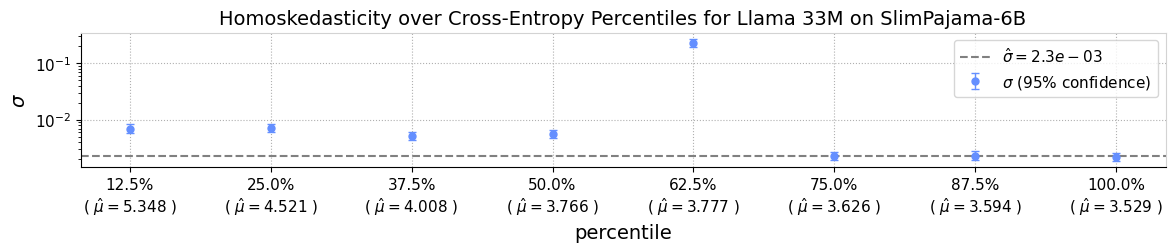

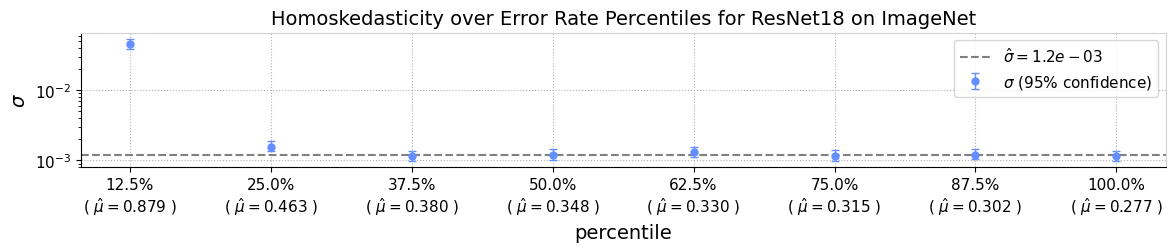

In [4]:
for experiment, quantile_to_hparams_and_ys in experiment_to_quantile_to_hparams_and_ys.items():
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(14, 1.75),
    )

    # Since all the samples are independent, use Šidák's correction to
    # make the intervals hold simultaneously.
    confidence_corrected = confidence_residual**(1/n_residual_groups)

    quantiles = []
    u_pts = []
    o_pts = []
    o_los = []
    o_his = []
    for quantile, (_, ys) in quantile_to_hparams_and_ys.items():
        n = len(ys)

        chi2 = stats.chi2(n - 1)

        u_pt = np.mean(ys)
        o_pt = np.std(ys, ddof=1)
        o_lo = ((n - 1) / chi2.ppf(1 - (1 - confidence_corrected) / 2))**0.5 * o_pt
        o_hi = ((n - 1) / chi2.ppf((1 - confidence_corrected) / 2))**0.5 * o_pt

        quantiles.append(quantile)
        u_pts.append(u_pt)
        o_pts.append(o_pt)
        o_los.append(o_lo)
        o_his.append(o_hi)

    quantiles = np.array(quantiles)
    u_pts = np.array(u_pts)
    o_pts = np.array(o_pts)
    o_los = np.array(o_los)
    o_his = np.array(o_his)

    o_hat = np.mean(o_pts[-3:])

    ax.errorbar(
        quantiles,
        o_pts,
        yerr=(o_pts - o_los, o_his - o_pts),
        label=rf"$\sigma$ ({100 * confidence_residual:.0f}% confidence)",
        marker="o",
        markersize=5,
        elinewidth=1,
        capsize=3,
        capthick=1,
        fmt="o",
        color=styles["empirical"]["color"],
    )

    ax.axhline(
        o_hat,
        label=rf"$\hat{{\sigma}} = {o_hat:.1e}$",
        linestyle="--",
        c="gray",
    )
    ax.set_xticks(quantiles)
    ax.set_xticklabels([
        f"{100 * quantile:.1f}%"
        f"\n( $\\hat{{\\mu}} = {u_pt:.3f}$ )"
        for quantile, u_pt in zip(quantiles, u_pts)
    ])
    ax.set_yscale("log")
    ax.spines["right"].set_color("lightgrey")
    ax.spines["top"].set_color("lightgrey")
    ax.set_xlabel("percentile")
    ax.set_ylabel(r"$\sigma$")
    ax.set_title(
        f"Homoskedasticity over {experiments[experiment]['metric'].title()} Percentiles"
        f" for {experiments[experiment]['model']}"
        f" on {experiments[experiment]['dataset']}",
    )
    ax.legend()

    plt.show()

For ResNet18, the worst hyperparameters have inflated variance (on the left). Intuitively, bad hyperparameters are highly sensitive to the random seed. Nonetheless, the variance quickly drops and then remains at a constant level. We approximate this level by averaging the last three standard deviation estimates on the right, and mark it with a dashed horizontal line. This constant level is achieved somewhere between the 25th and 37.5th percentiles, after which all estimates' confidence bands contain the dashed line. Importantly, the level is achieved long before we hit the asymptotic regime around the 65th percentile. Thus, the figure provides compelling support for homoskedasticity!

For Llama 33M, the story is again similar but with a subtle twist. The variance begins inflated; however, as the hyperparameters improve the variance drops to a constant level. Again, we estimate this level by averaging the last three standard deviation estimates. Constant variance is achieved later than ResNet18 and, just before the variance becomes constant, the hyperparameters at the 62.5th percentile show massively inflated variance, a variance higher than even the worst hyperparameters we tested. In a moment, we'll see this variance is inflated due to instability in those hyperparameters. For now, note that while the configuration originally scored a cross-entropy of 3.67 (the 62.5th percentile) in our original tuning experiment, here we see a much higher expected cross-entropy of 3.78. By the original estimate, the configuration falls within the asymptotic regime which starts at 3.695; however, our more reliable estimate suggests that it should be excluded from it. In this sense, we see homoskedasticity emerge for all configurations in the asymptotic regime, but at the same time these unstable training configurations can randomly score values below the asymptotic regime's threshold.

Clearly, we should try to better understand such training instabilities&mdash;an investigation which we take up next.

## Investigating Training Instabilities

Let's dig into what's going on with the 62.5th percentile configuration for Llama 33M.

In [5]:
experiment = "llama-33m_residual"
quantile = 0.625

training_curves = experiment_to_quantile_to_training_curves[experiment][quantile]
hparams, ys = experiment_to_quantile_to_hparams_and_ys[experiment][quantile]

Here's what the hyperparameters were for each quantile:

In [6]:
quantile_hparams_table = []
for quantile_, (hparams_, _) in experiment_to_quantile_to_hparams_and_ys[experiment].items():
    if len(quantile_hparams_table) == 0:
        quantile_hparams_table.append(
            "| "  # noqa: ISC003
            + "quantile     | "
            + (" | ".join(f"{k: <12}" for k in hparams_[0].keys()))
            + " |",
        )
        quantile_hparams_table.append(
            "| "
            + (" | ".join("-" * 12 for _ in range(len(hparams_[0].keys()) + 1)))
            + " |",
        )
    quantile_hparams_table.append(
        ("| " if quantile_ != quantile else "* ")
        + f"{100 * quantile_: >11.1f}% | "
        + (" | ".join(f"{v: >12}" for v in hparams_[0].values()))
        + (" |" if quantile_ != quantile else " *"),
    )

print("\n".join(quantile_hparams_table))

| quantile     | warmup_steps | lr           | beta1        | beta2        | weight_decay | dropout      |
| ------------ | ------------ | ------------ | ------------ | ------------ | ------------ | ------------ |
|        12.5% |         2691 |  1.16137e-05 |     0.936556 |      0.86896 |    0.0325858 |    0.0771501 |
|        25.0% |          749 |   3.2492e-05 |     0.777596 |     0.961669 |     0.613329 |    0.0899591 |
|        37.5% |         1621 |  9.40299e-05 |     0.876661 |     0.904793 |     0.303457 |    0.0745805 |
|        50.0% |         2188 |    0.0230652 |     0.801746 |     0.875048 |      0.23422 |    0.0570982 |
*        62.5% |         2009 |    0.0415404 |     0.872392 |     0.903077 |   0.00817632 |    0.0403913 *
|        75.0% |          822 |   0.00125068 |     0.870602 |     0.834747 |     0.222796 |     0.024949 |
|        87.5% |         1587 |   0.00765622 |     0.897487 |     0.907791 |  0.000574748 |    0.0683224 |
|       100.0% |         1448 |   0.0

The 62.5th quantile has a high learning rate, which perhaps explains the training instability. The learning rate is likely at the edge of what's trainable, leading the configuration to sometimes succeed and other times fail. Perhaps by setting the other hyperparameters carefully, the net can be coaxed to occasionally train with a high learning rate where it might otherwise diverge.

Let's look at the individual training runs for the 62.5th quantile. During training, when does the hyperparameters' instability cause problems? And, more generally, how does it impact the training curve?

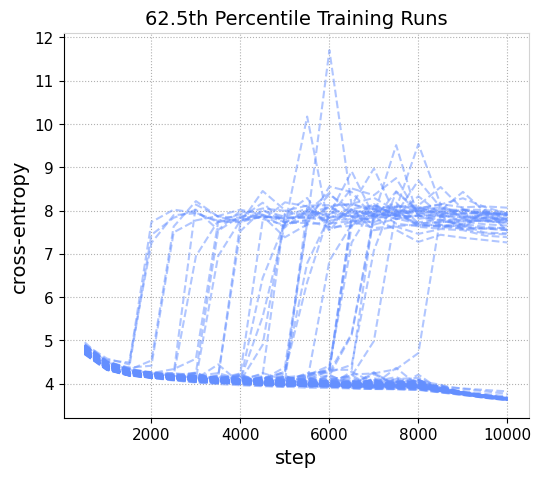

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

# Plot the training curves.
for training_curve in training_curves:
    ax.plot(
        *zip(*training_curve),
        alpha=0.5,
        **styles["empirical"],
    )

# Format the plot.
ax.set_xlabel("step")
ax.set_ylabel(experiments[experiment]["metric"])

ax.set_title(
    f"{100 * quantile:.1f}th Percentile"
    f" Training Runs",
)

ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

plt.show()

We see clear bimodal behavior. During training, some training runs experience a loss spike from which they never recover. Runs which don't experience such a spike train to a reasonably good loss. Our original training run in the tuning experiment was one such lucky run.

Let's compare these training runs to those from the the other percentiles and the ones from ResNet18.

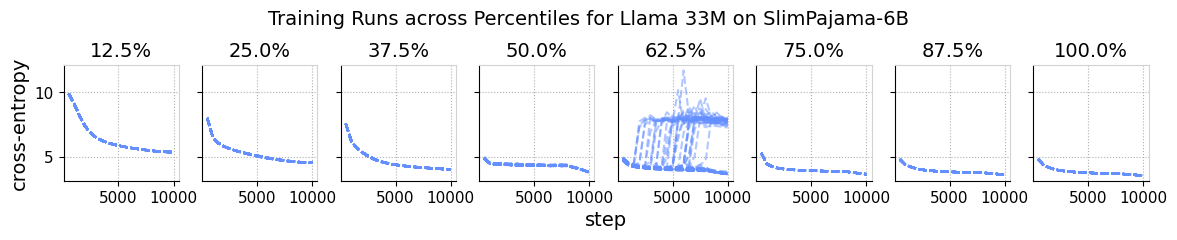

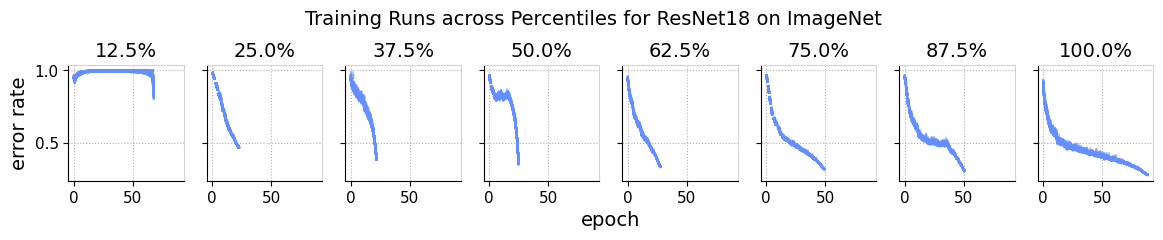

In [8]:
for experiment_, quantile_to_training_curves in experiment_to_quantile_to_training_curves.items():
    fig, axes = plt.subplots(
        nrows=1,
        ncols=n_residual_groups,
        figsize=(14, 1.5),
        sharex=True,
        sharey=True,
    )
    for i, (quantile_, training_curves_) in enumerate(quantile_to_training_curves.items()):
        # Plot the training curves.
        for training_curve in training_curves_:
            axes[i].plot(
                *zip(*training_curve),
                alpha=0.5,
                **styles["empirical"],
            )

        # Format the plot.
        axes[i].set_title(f"{100 * quantile_:.1f}%")

        axes[i].spines["right"].set_color("lightgrey")
        axes[i].spines["top"].set_color("lightgrey")

    # Format the figure.
    axes[3].set_xlabel(
        "step" if experiment_ == "llama-33m_residual" else "epoch",
        x=1.1,
    )
    axes[0].set_ylabel(experiments[experiment_]["metric"])

    fig.suptitle(
        f"Training Runs across Percentiles"
        f" for {experiments[experiment_]['model']}"
        f" on {experiments[experiment_]['dataset']}",
        y=1.25,
    )

    plt.show()

Only Llama 33M's 62.5th percentile exhibits the bimodal training instability. For all other hyperparameter configurations, the training runs cluster around a similar trajectory.

Beyond the training runs, let's take a closer look at the score distribution that the 62.5th percentile configuration induces. We'll visualize the distribution with a QQ plot (against the normal distribution), a CDF plot, and a PDF plot:

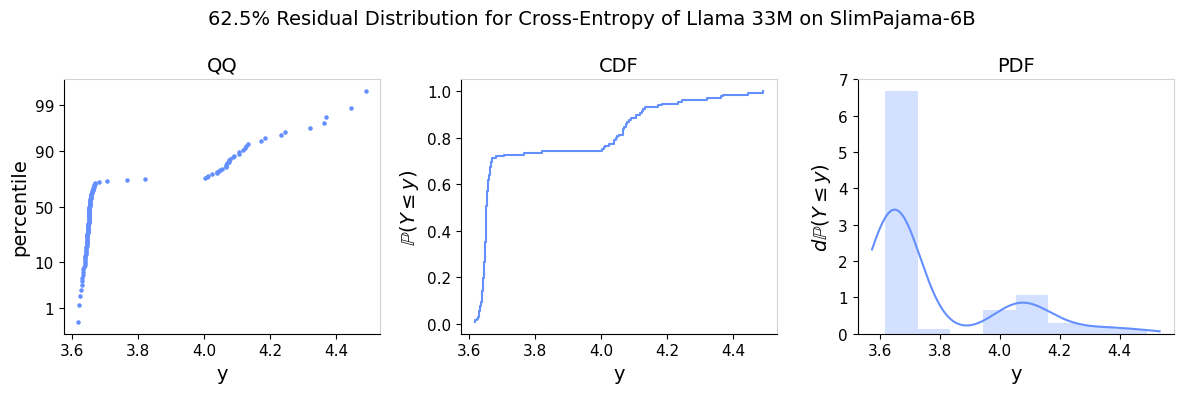

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

(n,) = ys.shape
y_min, y_max = np.min(ys), np.max(ys)

y_lo, y_hi = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
ys_grid = np.linspace(y_lo, y_hi, num=1_024)

# Plot the normal probability plot.
axes[0].scatter(
    np.sort(ys),
    normal_ppf((0.5 + np.arange(n)) / n),
    s=5,
    c=styles["empirical"]["color"],
)
# Plot the CDF.
axes[1].step(
    np.sort(ys),
    (1 + np.arange(n)) / n,
    where="post",
    c=styles["empirical"]["color"],
)
# Plot the PDF.
axes[2].hist(
    ys,
    bins="auto",
    density=True,
    alpha=0.275,
    color=styles["empirical"]["color"],
)
axes[2].plot(
    ys_grid,
    stats.gaussian_kde(ys).pdf(ys_grid),
    color=styles["empirical"]["color"],
)

# Format the figure.
axes[0].set_yticks(
    ticks=normal_ppf([0.01, 0.1, 0.5, 0.90, 0.99]),
    labels=["1", "10", "50", "90", "99"],
)

for i, (x_label, y_label, title) in enumerate([
    ("y",  "percentile", "QQ"),
    ("y", r"$\mathbb{P}(Y \leq y)$", "CDF"),
    ("y", r"$d\mathbb{P}(Y \leq y)$", "PDF"),
]):
    axes[i].set_xlabel(x_label)
    axes[i].set_ylabel(y_label)
    axes[i].set_title(title)
    axes[i].grid(visible=False)
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"{100 * quantile:.1f}%"
    f" Residual Distribution"
    f" for {experiments[experiment]['metric'].title()}"
    f" of {experiments[experiment]['model']}"
    f" on {experiments[experiment]['dataset']}",
)

fig.tight_layout()

plt.show()

The QQ, CDF, and PDF plots again show the distribution is bimodal. It is a mixture of two components: one where training succeeds, and one where it fails. From the CDF, we see that training succeeds a little more than 70% of the time, obtaining a final cross-entropy as good or better than about 3.7. The other 30% of the time, training fails, obtaining a cross-entropy worse than 4.

The QQ plot hints at the structure of the two components. In a QQ plot, the sorted data are plotted against the quantiles of some base distribution (e.g., the standard normal). A line represents that same distribution except possibly translated and rescaled (a location-scale family). A piecewise-linear graph then often corresponds to a mixture of two such translated, rescaled distributions. So, the piecewise-linear graph in the QQ plot here suggests that the residual distribution is approximately a mixture of two normals. The piecewise linear structure isn't perfect, so this is a rough approximation, but a useful one.

Let's look closer at the mixture components. For now, we'll separate them using a simple threshold at 3.7 cross-entropy.

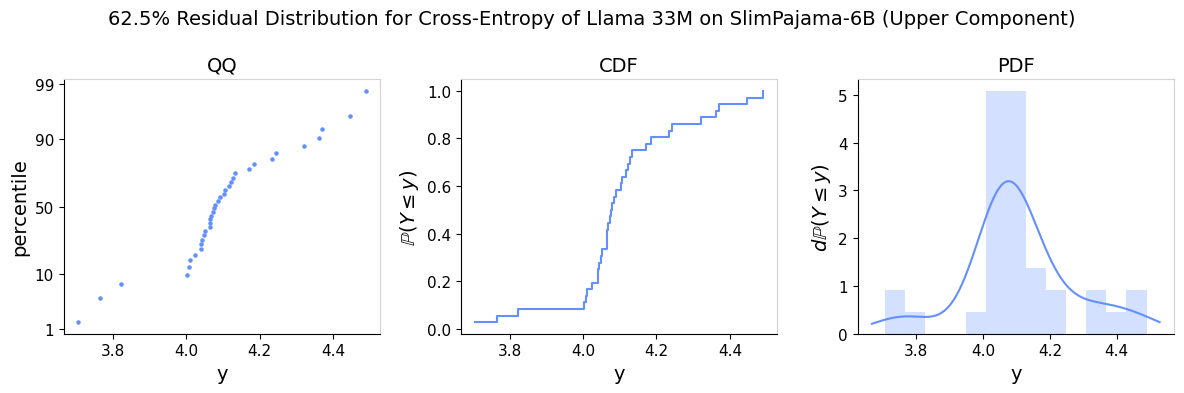

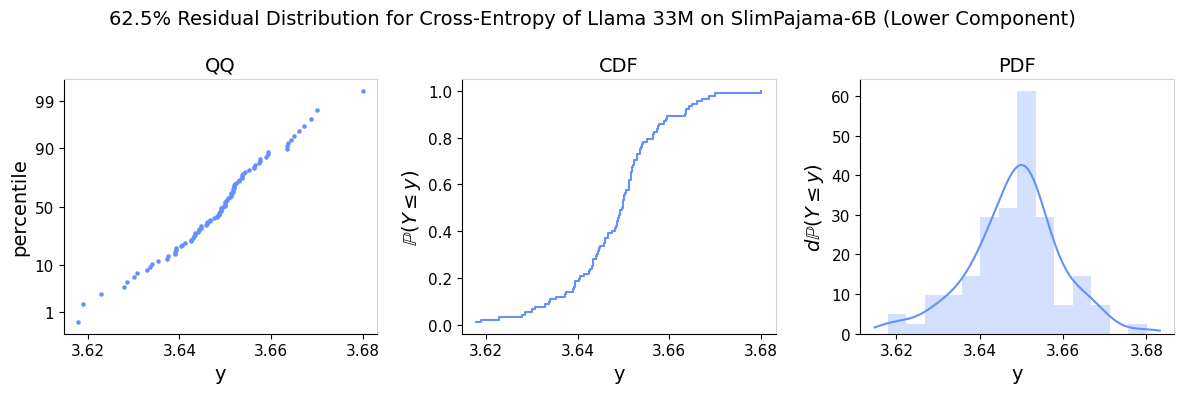

In [10]:
mixture_threshold = 3.7
for lower in [False, True]:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    ys_ = (
        ys[ys <= mixture_threshold]  if lower else
        ys[ys > mixture_threshold] # if upper
    )

    (n,) = ys_.shape
    y_min, y_max = np.min(ys_), np.max(ys_)

    y_lo, y_hi = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
    ys_grid = np.linspace(y_lo, y_hi, num=1_024)

    # Plot the normal probability plot.
    axes[0].scatter(
        np.sort(ys_),
        normal_ppf((0.5 + np.arange(n)) / n),
        s=5,
        c=styles["empirical"]["color"],
    )
    # Plot the CDF.
    axes[1].step(
        np.sort(ys_),
        (1 + np.arange(n)) / n,
        where="post",
        c=styles["empirical"]["color"],
    )
    # Plot the PDF.
    axes[2].hist(
        ys_,
        bins="auto",
        density=True,
        alpha=0.275,
        color=styles["empirical"]["color"],
    )
    axes[2].plot(
        ys_grid,
        stats.gaussian_kde(ys_).pdf(ys_grid),
        color=styles["empirical"]["color"],
    )

    # Format the figure.
    axes[0].set_yticks(
        ticks=normal_ppf([0.01, 0.1, 0.5, 0.90, 0.99]),
        labels=["1", "10", "50", "90", "99"],
    )

    for i, (x_label, y_label, title) in enumerate([
        ("y",  "percentile", "QQ"),
        ("y", r"$\mathbb{P}(Y \leq y)$", "CDF"),
        ("y", r"$d\mathbb{P}(Y \leq y)$", "PDF"),
    ]):
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(y_label)
        axes[i].set_title(title)
        axes[i].grid(visible=False)
        axes[i].spines["right"].set_color("lightgrey")
        axes[i].spines["top"].set_color("lightgrey")

    fig.suptitle(
        f"{100 * quantile:.1f}%"
        f" Residual Distribution"
        f" for {experiments[experiment]['metric'].title()}"
        f" of {experiments[experiment]['model']}"
        f" on {experiments[experiment]['dataset']}"
        f" ({'Lower' if lower else 'Upper'} Component)",
    )

    fig.tight_layout()

    plt.show()

Among successful training runs, our original run obtained a fairly typical score: 3.67 cross-entropy. Therefore, it would not be unusual for such a configuration to appear as if it belongs in the asymptotic regime.

When the model trains successfully, it exhibits a reasonable degree of normality. When training fails, the distribution is less well approximated by a normal, though we could still treat it as such in a qualitative analysis. Let's do just that and decompose the distribution using a Gaussian mixture.

In [11]:
# Fit the Gaussian mixture model.
gmm = GaussianMixture(
    n_components=2,
    covariance_type="diag",
    n_init=10,
    init_params="k-means++",
    random_state=generator,
).fit(ys[:, None])

Using the Gaussian mixture model, we can assign each validation score a posterior probability for which component it comes from.

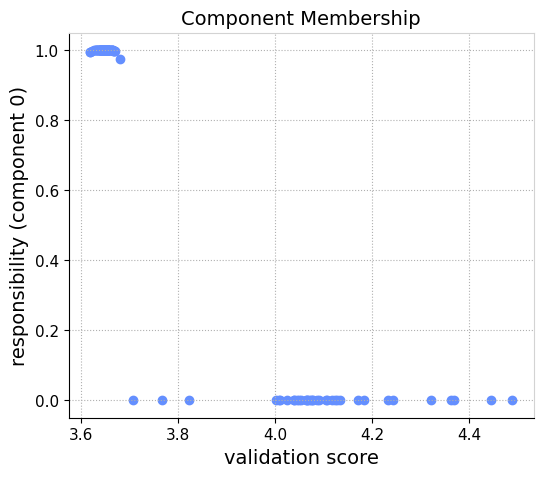

In [12]:
# Compute posterior probabilities for the component each point comes from.
#     posterior ~ prior x likelihood
rs = gmm.weights_[None, :] * gmm.predict_proba(ys[:, None])
rs /= np.sum(rs, axis=1, keepdims=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

# Plot the responsibilities.
ax.scatter(
    ys,
    rs[:, 0],
    color=styles["empirical"]["color"],
)

# Format the plot.
ax.set_xlabel("validation score")
ax.set_ylabel("responsibility (component 0)")

ax.set_title("Component Membership")

ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

plt.show()

We see that each score unambiguously belongs to one component or the other; so, we'll make a hard assignment of scores to components. With this assignment, we can redo our normality analysis except separating the two components.

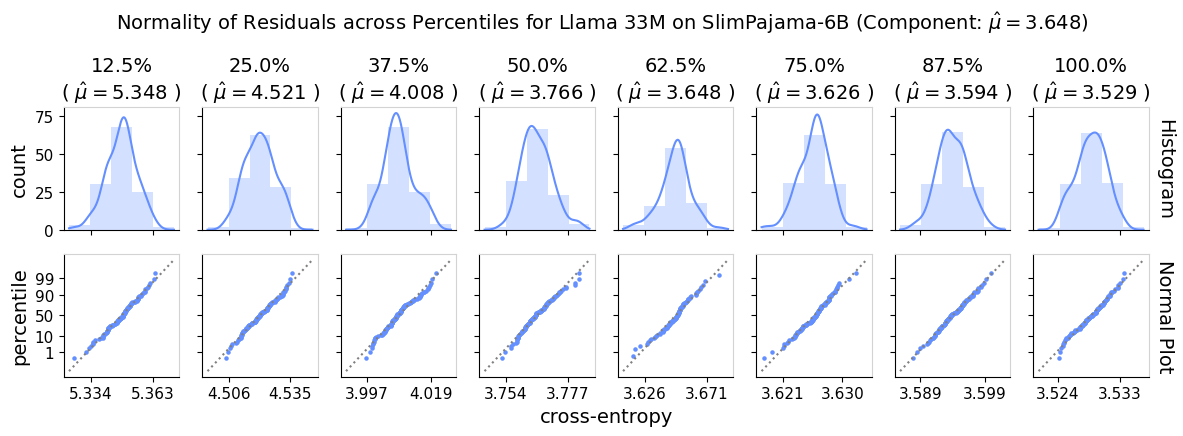

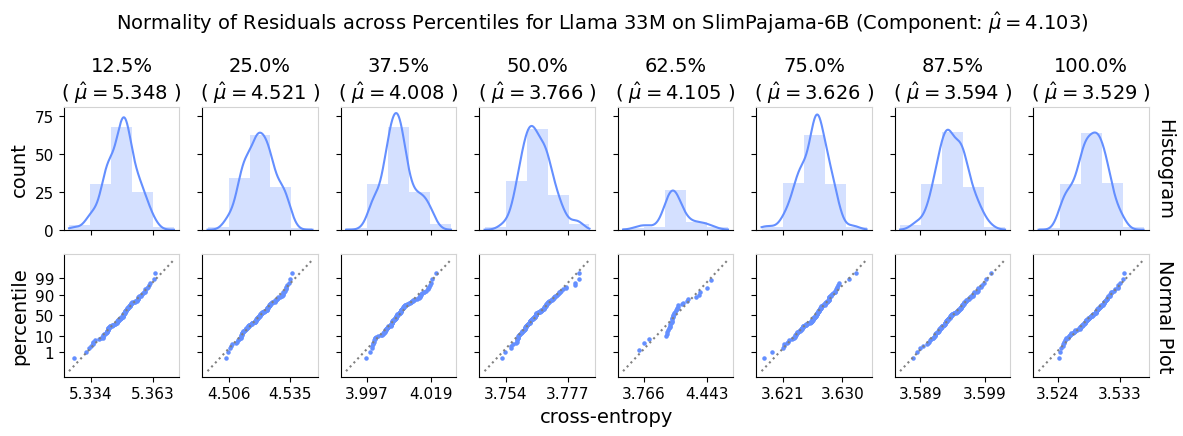

In [13]:
for component in [0, 1]:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=n_residual_groups,
        figsize=(14, 3.5),
        sharex="col",
        sharey="row",
    )
    for j, (quantile_, (_, ys_)) in enumerate(
        experiment_to_quantile_to_hparams_and_ys[experiment].items(),
    ):
        if quantile_ == quantile:
            ys_ = ys_[gmm.predict(ys_[:, None]) == component]

        n = len(ys_)
        u_hat, o_hat = np.mean(ys_), np.std(ys_, ddof=1)
        y_lo, y_hi = u_hat - 3.5 * o_hat, u_hat + 3.5 * o_hat
        if np.any(ys_ < y_lo) or np.any(ys_ > y_hi):
            raise RuntimeError(
                "Some ys fall outside the visualization.",
            )

        ys_grid = np.linspace(y_lo, y_hi, num=1_024)

        # Plot the PDFs.
        axes[0, j].hist(
            ys_,
            bins=np.linspace(y_lo, y_hi, num=6),
            density=False,
            alpha=0.275,
            color=styles["empirical"]["color"],
        )
        axes[0, j].plot(
            ys_grid,
            n * (y_hi - y_lo) / 5 * stats.gaussian_kde(ys_).pdf(ys_grid),
            linestyle="-",
            color=styles["empirical"]["color"],
        )

        # Plot the normal probability plots.
        axes[1, j].plot(
            ys_grid,
            (ys_grid - u_hat) / o_hat,
            linestyle=":",
            c="gray",
        )
        axes[1, j].scatter(
            np.sort(ys_),
            normal_ppf((0.5 + np.arange(n)) / n),
            s=5,
            c=styles["empirical"]["color"],
        )

        # Format the plot.
        axes[1, j].set_xticks(np.round(
            [y_lo + (y_hi - y_lo) / 5, y_lo + 4 * (y_hi - y_lo) / 5],
            decimals=3,
        ))
        axes[1, j].set_yticks(
            ticks=normal_ppf([0.01, 0.1, 0.5, 0.90, 0.99]),
            labels=["1", "10", "50", "90", "99"],
        )
        axes[0, j].set_title(
            f"{100 * quantile_:.1f}%"
            f"\n( $\\hat{{\\mu}} = {u_hat:.3f}$ )",
        )
        for i in range(2):
            axes[i, j].grid(visible=False)
            axes[i, j].spines["right"].set_color("lightgrey")
            axes[i, j].spines["top"].set_color("lightgrey")

    # Format the figure.
    axes[1, 3].set_xlabel(experiments[experiment]["metric"], x=1.1)
    axes[0, 0].set_ylabel("count")
    axes[1, 0].set_ylabel("percentile")
    axes[0, -1].yaxis.set_label_position("right")
    axes[0, -1].set_ylabel("Histogram", labelpad=18, rotation=270)
    axes[1, -1].yaxis.set_label_position("right")
    axes[1, -1].set_ylabel("Normal Plot", labelpad=18, rotation=270)

    fig.suptitle(
        rf"Normality of Residuals across Percentiles"
        rf" for {experiments[experiment]['model']}"
        rf" on {experiments[experiment]['dataset']}"
        rf" (Component: $\hat{{\mu}}={gmm.means_[component, 0]:.3f}$)",
        x=0.51, y=1.16,
    )

    plt.show()

Splitting out the components, we see the successful training runs achieve the expected level of normality. In contrast, the unsuccessful runs seem less normal than one might expect.

Let's look at homoskedasticity.

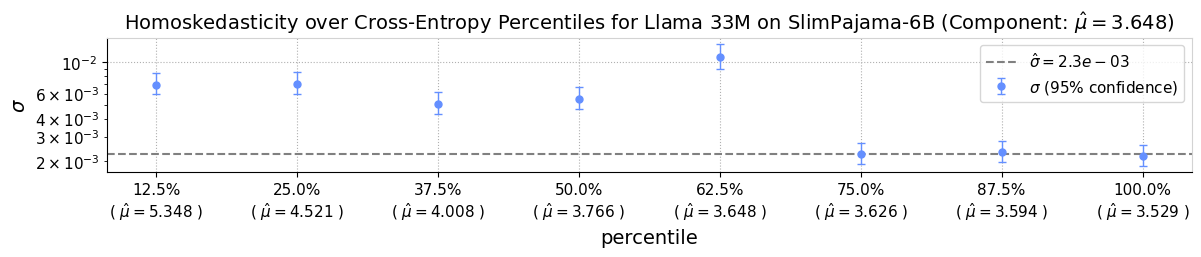

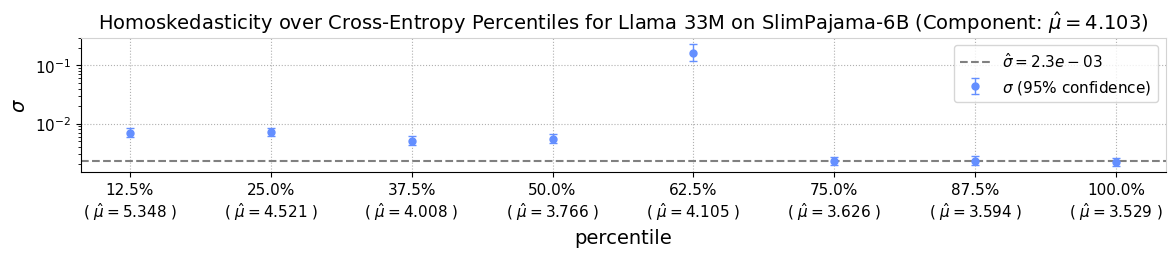

In [14]:
for component in [0, 1]:
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(14, 1.75),
    )

    # Since all the samples are independent, use Šidák's correction to
    # make the intervals hold simultaneously.
    confidence_corrected = confidence_residual**(1/n_residual_groups)

    quantiles = []
    u_pts = []
    o_pts = []
    o_los = []
    o_his = []
    for quantile_, (_, ys_) in experiment_to_quantile_to_hparams_and_ys[experiment].items():
        if quantile_ == quantile:
            ys_ = ys_[gmm.predict(ys_[:, None]) == component]

        n = len(ys_)

        chi2 = stats.chi2(n - 1)

        u_pt = np.mean(ys_)
        o_pt = np.std(ys_, ddof=1)
        o_lo = ((n - 1) / chi2.ppf(1 - (1 - confidence_corrected) / 2))**0.5 * o_pt
        o_hi = ((n - 1) / chi2.ppf((1 - confidence_corrected) / 2))**0.5 * o_pt

        quantiles.append(quantile_)
        u_pts.append(u_pt)
        o_pts.append(o_pt)
        o_los.append(o_lo)
        o_his.append(o_hi)

    quantiles = np.array(quantiles)
    u_pts = np.array(u_pts)
    o_pts = np.array(o_pts)
    o_los = np.array(o_los)
    o_his = np.array(o_his)

    o_hat = np.mean(o_pts[-3:])

    ax.errorbar(
        quantiles,
        o_pts,
        yerr=(o_pts - o_los, o_his - o_pts),
        label=rf"$\sigma$ ({100 * confidence_residual:.0f}% confidence)",
        marker="o",
        markersize=5,
        elinewidth=1,
        capsize=3,
        capthick=1,
        fmt="o",
        color=styles["empirical"]["color"],
    )

    ax.axhline(
        o_hat,
        label=rf"$\hat{{\sigma}} = {o_hat:.1e}$",
        linestyle="--",
        c="gray",
    )
    ax.set_xticks(quantiles)
    ax.set_xticklabels([
        f"{100 * quantile_:.1f}%"
        f"\n( $\\hat{{\\mu}} = {u_pt:.3f}$ )"
        for quantile_, u_pt in zip(quantiles, u_pts)
    ])
    ax.set_yscale("log")
    ax.spines["right"].set_color("lightgrey")
    ax.spines["top"].set_color("lightgrey")
    ax.set_xlabel("percentile")
    ax.set_ylabel(r"$\sigma$")
    ax.set_title(
        rf"Homoskedasticity over {experiments[experiment]['metric'].title()} Percentiles"
        rf" for {experiments[experiment]['model']}"
        rf" on {experiments[experiment]['dataset']}"
        rf" (Component: $\hat{{\mu}}={gmm.means_[component, 0]:.3f}$)",
    )
    ax.legend()

    plt.show()

Similarly to the normality plots, splitting out the successful and unsuccessful training runs makes homoskedasticity look more in line with our expectations; however, the 62.5th percentile still shows an inflated variance. Thus, the training stability both makes the distribution bimodal and increases the variance of the good component beyond what we might otherwise expect. Perhaps even when the training runs escape divergence, their progress is still impeded by the time spent on the edge of it.

## Conclusion

What can we conclude from our investigation?

In both models, normality and homoskedasticity are achieved as we approach the optimum. For ResNet18 on ImageNet, this structure emerges somewhere around the 37.5th percentile of loss&mdash;long before the the asymptotic regime which emerges around the 65.7th percentile. For Llama on SlimPajama-6B, the story is broadly the same, but with an important detail: around the edge of the asymptotic regime, we found an unstable hyperparameter configuration. In 70% of runs, the configuration trains successfully; in 30% of runs, the loss spikes up and never recovers. Looking only at the succesful training runs, they fall more in line with our expectations&mdash;achieving normality and showing only a moderately inflated variance. When you discard the hyperparameter configurations and only look at their associated scores (i.e., on the margin), the failed training runs fall outside the asymptotic regime. This explains why the marginal distribution still looks much like a noisy quadratic even where such instabilities occur. Of course, you can also restrict your attention even closer to the optimum, where the structure appears even more regular.

In summary, the variation due to random seeds looks largely normal and homoskedastic in the asymptotic regime. Training instabilities exist for some models, creating bimodal behavior for certain hyperparameter configurations. The unstable configuration we found sits near the boundary of the asymptotic regime. One might guess that unstable configurations tend to pop up there, though it will take future research to fully answer that question.